In [4]:
import numpy as np
from mrmustard.lab import Circuit, SqueezedVacuum, Number
from mrmustard.lab.transformations import BSgate
from mrmustard.physics.wigner import wigner_discretized
import matplotlib.pyplot as plt

In [5]:
seed = 42
rng = np.random.default_rng(seed)

# Set number of modes, maximal squeezing and maximal number of photons detected
# Note: larger squeezing and higher photon numbers lead to rarer events
# and noisier conditional states
N = 3
max_r = 0.8  # recommended bound for tractable simulation
max_n = 3

# Generate input squeezed states
squeezing_params = rng.uniform(0, max_r, size=N)
input_state = [
    SqueezedVacuum(i, r, phi=(0 if i % 2 == 1 else np.pi/2))
    for i, r in enumerate(squeezing_params)
]

# Generate interferometer randomly
def random_BS(mode1, mode2):
    # Mixing angle
    theta = rng.uniform(0, np.pi/2)
    # Relative phase
    phi = rng.uniform(0, 2*np.pi)
    BS = BSgate([mode1, mode2], theta, phi)
    return BS, [theta, phi]

# Three beam splitters are sufficient to generate an arbitrary 3-mode interferometer.
# Students are encouraged to experiment with fewer or more.
BS1, BS1_params = random_BS(0, 1)
BS2, BS2_params = random_BS(1, 2)
BS3, BS3_params = random_BS(0, 1)
BS_params = [BS1_params, BS2_params, BS3_params]

interferometer = BS1 >> BS2 >> BS3

# Generate random measurement numbers
photon_numbers = rng.integers(0, max_n + 1, size=N-1)

params = {
    "squeezing": squeezing_params,
    "beam_splitters": BS_params,
    "photon_numbers": photon_numbers,
}

measurement = [Number(i, n).dual for i, n in enumerate(photon_numbers)]

# Realize circuit and get output state (out)
c = Circuit(input_state) >> interferometer >> Circuit(measurement)
out = c.contract().normalize()

# Print information
print("Circuit parameters:")
for k, v in params.items():
    print(f"  {k}: {v}")

Circuit parameters:
  squeezing: [0.61916484 0.35110275 0.68687834]
  beam_splitters: [[1.0954231384706454, 0.5917337285168199], [1.532504006290015, 4.782381792256834], [1.2347469233536212, 0.8049616944763924]]
  photon_numbers: [3 1]


In [6]:
display(out)

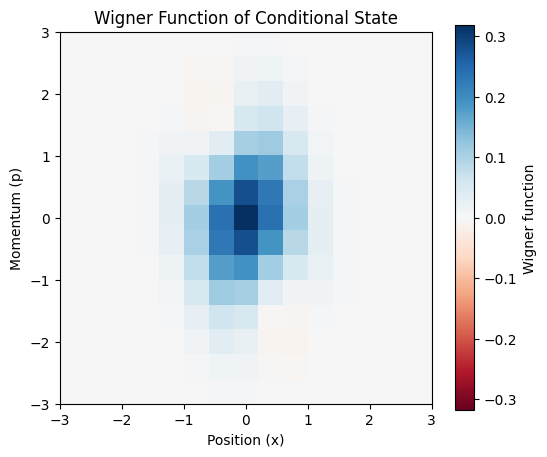

In [7]:
# Adjust format of pixelized wigner function
x = 3.0      # phase-space cutoff
Np = 15      # number of pixels per axis
xvec = np.linspace(-x, x, Np)
pvec = np.linspace(-x, x, Np)
wig, X, P = wigner_discretized(out.dm().ansatz.array, xvec, pvec)

# Visualize Wigner function
plt.figure(figsize=(6, 5))
plt.imshow(wig.T, vmin=-1/np.pi, vmax=1/np.pi, cmap='RdBu', extent=[-x, x, -x, x], origin='lower')
plt.colorbar(label='Wigner function')
plt.xlabel('Position (x)')
plt.ylabel('Momentum (p)')
plt.title('Wigner Function of Conditional State')
plt.show()